# Register to ARA

The aim is to register individual slices to the Allen Reference Atlas. Example solutions
for this type of registration are described here:
https://forum.image.sc/t/comparison-of-some-tools-for-brain-slice-to-atlas-registration/43260

We will start with ABBA. This require a stitched overview of one slice in a pyramidal format.

## Stitch example round

First step is to stitch on slice.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import iss_preprocess as iss
from tifffile import imread, imsave
from iss_preprocess.io.save import write_stack
import matplotlib.pyplot as plt
from flexiznam.config import PARAMETERS
import numpy as np
from pathlib import Path
from iss_preprocess.image import correction

project = "becalia_rabies_barseq"
mouse = "BRYC65.1d"
chamber = "chamber_13"
ref_acq = "DAPI_1"
dark_frame = "becalia_iss_microscope/calibration/20221209_dark_frame"

raw = Path(PARAMETERS["data_root"]["raw"])
data_path = Path(project) / mouse / chamber
processed = Path(PARAMETERS["data_root"]["processed"])
registration_folder = processed / data_path / "register_to_ara"
registration_folder.mkdir(exist_ok=True)


### Get calibration

First step is to find the dark value to compute correction image

In [3]:
# get dark frame
calib_path = Path(PARAMETERS["data_root"]["processed"]) / dark_frame
dark_tiff = list(calib_path.glob("*.tif"))
assert len(dark_tiff) == 1
black_level, readout_noise = correction.analyze_dark_frames(dark_tiff[0])
print(black_level)


[38.4525411  38.24207294 38.45687868 38.46573468]


### Make correction image

Then we can generate the correction image by averaging alllllll the tiffs. That takes
time so we will save one average per folder.

In [4]:
REDO = False
average_dir = processed / data_path / "averages"
average_dir.mkdir(exist_ok=True)
if REDO:
    from iss_preprocess import pipeline
    pipeline.create_all_single_averages(data_path=data_path, max_value=2000)


In [6]:
REDO = False

if REDO:
    from iss_preprocess import pipeline

    pipeline.create_grand_averages(
        data_path=data_path,
        max_value=2000,
        black_level=black_level,
        normalise=True,
        median_filter=5,
        use_slurm=False
    )


In [7]:
# Load generated averages
from iss_preprocess.io.load import load_stack
correction_images = dict()

for fname in average_dir.glob('*average.tif'):
    correction_images[fname.name.replace("_average.tif", "")] = load_stack(fname)


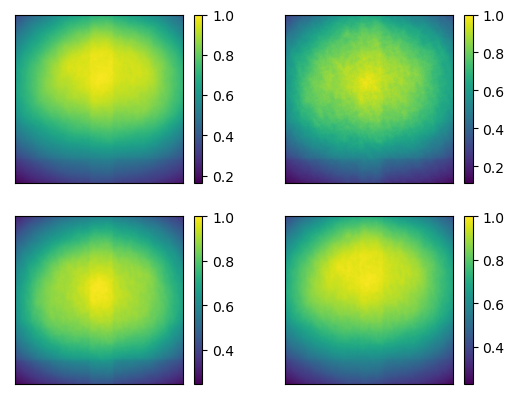

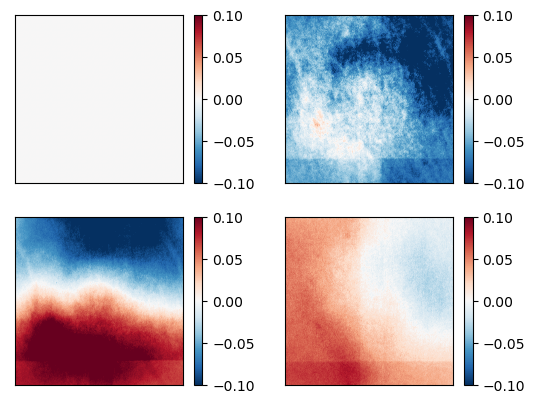

In [8]:
# compare 4 channels
correction_image = correction_images["genes_round"]
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2, 2, 1 + i)
    img = ax.imshow(correction_image[:, :, i])
    plt.colorbar(img)
    ax.set_xticks([])
    ax.set_yticks([])
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2, 2, 1 + i)
    img = ax.imshow(
        correction_image[:, :, i] - correction_image[:, :, 0],
        cmap="RdBu_r",
        vmin=-0.1,
        vmax=0.1,
    )
    plt.colorbar(img)
    ax.set_xticks([])
    ax.set_yticks([])


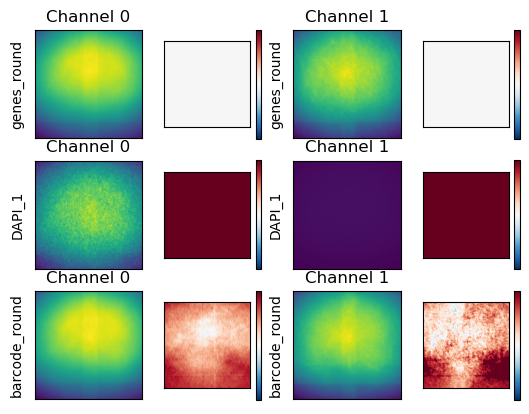

In [9]:
# compar channel 0 and 1 of different rounds
nrows = 3
fig = plt.figure()


for iax, corr in enumerate(["genes_round", "DAPI_1", "barcode_round"]):
    data = correction_images[corr]
    for ch in [0, 1]:
        ax = plt.subplot(nrows, 4, 1 + iax * 4 + ch * 2)
        ax.imshow(data[:, :, ch])
        ax.set_ylabel(corr)
        ax.set_title("Channel {0}".format(ch))
        ax = plt.subplot(nrows, 4, 2 + iax * 4 + ch * 2)
        img = ax.imshow(
            data[:, :, ch] - correction_image[:, :, ch],
            vmin=-0.1,
            vmax=0.1,
            cmap="RdBu_r",
        )
        plt.colorbar(img)
for x in fig.axes:
    x.set_xticks([])
    x.set_yticks([])


## Stitch tiles

We will take all rois in the `ref_acq` and stitch them. The save the generated image in
`registration_folder`.

In [10]:
from tifffile import TiffWriter
import cv2

pixel_size = 0.1862
from iss_preprocess.io.save import save_ome_tiff_pyramid


In [12]:
# find the number of ROIs and the number of tiles per roi from file names
import re
import pandas as pd
import numpy as np
round = 1
prefix="DAPI"
suffix="fstack"
pattern = fr"{prefix}_{round}_MMStack_(\d*)-Pos(\d\d\d)_(\d\d\d)_{suffix}.tif"

find_acq = re.compile(pattern)
data = dict()
for fname in (processed /  data_path / ref_acq).iterdir():
    m = find_acq.match(fname.name)
    if m:
        nroi, tile_x, tile_y = np.array(m.groups(), dtype=int)
        if not nroi in data:
            data[nroi] = []
        data[nroi].append([tile_x, tile_y])
data = {k: np.vstack(v) for k, v in data.items()}
ntiles_per_roi = {k: np.max(v, axis=0) + 1 for k, v in data.items()}
print("Found %d ROIs." % len(ntiles_per_roi))


Found 8 ROIs.


In [13]:
REDO = True
SAVE_CHANNELS = True
valid_channels = [0, 1, 2, 3]
prefix = "genes_round_1_1"
DO_ONE = False  # do only one and stop (useful to create variables to debug)
for roi_num, ntiles in ntiles_per_roi.items():
    target = registration_folder / "{0}_stitched_roi_{1}.ome.tif".format(
        prefix, roi_num
    )
    print(target)


/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_8.ome.tif
/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_1.ome.tif
/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_3.ome.tif
/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_4.ome.tif
/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_7.ome.tif
/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_6.ome.tif
/camp/lab/znamenskiyp/home/shared/projects/becalia_rabies_barseq/BRYC65.1d/chamber_13/register_to_ara/genes_round_1_1_stitched_roi_5.ome.tif
/camp/lab/zna

In [17]:
ref_tile

(8, 9, 6)

In [20]:
REDO = True
SAVE_CHANNELS = False
valid_channels = [0, 1, 2, 3]
prefix = "genes_round_1_1"
DO_ONE = False  # do only one and stop (useful to create variables to debug)
for roi_num, ntiles in ntiles_per_roi.items():
    target = registration_folder / f"{prefix}_stitched_roi_{roi_num}.ome.tif"
    if target.exists() and not REDO:
        print("%s already exists." % target.name)
        continue
    print("Doing roi %d (%d by %d tiles)" % (roi_num, *ntiles))
    # take a reference tile in the middle
    ref_tile = (roi_num, *np.array(ntiles / 2, dtype=int))
    # find shift
    print(" ... find shift")
    shift_right, shift_down, tile_shape = iss.pipeline.register_adjacent_tiles(
        data_path, ref_coors=ref_tile, prefix=prefix, suffix="fstack"
    )
    # find where to put each tile
    print(" ... find tile position")
    tile_origins, tile_centers = iss.pipeline.calculate_tile_positions(
        shift_right, shift_down, tile_shape, ntiles
    )
    # generate output image
    print(" ... stitching")
    out = None
    for channel in valid_channels:
        stitched_stack = iss.pipeline.stitch_tiles(
            data_path,
            prefix=prefix,
            suffix="fstack",
            shift_right=shift_right,
            shift_down=shift_down,
            roi=roi_num,
            ich=channel,
            black_level=black_level[channel],
            correction_image=correction_image[:, :, channel],
        )
        if out is None:
            out = np.zeros((len(valid_channels), *stitched_stack.shape))
        out[channel] = stitched_stack
        if SAVE_CHANNELS:
            # save output
            print(" ... saving channel %d" % channel)
            target = registration_folder / "stitched_roi_{0}_ch{1}.ome.tif".format(
                roi_num, channel
            )
            smallest = save_ome_tiff_pyramid(
                target,
                stitched_stack,
                pixel_size=pixel_size,
                subresolutions=5,
                max_size=3,
            )
    print(" ... saving")
    projection = np.nanmean(out, axis=0)
    target = registration_folder / "{0}_stitched_roi_{1}.ome.tif".format(
        prefix, roi_num
    )
    smallest = save_ome_tiff_pyramid(
        target, projection, pixel_size=pixel_size, subresolutions=5, max_size=3
    )
    if DO_ONE:
        break
print("Done!")


Doing roi 8 (18 by 12 tiles)
 ... find shift
 ... find tile position
 ... stitching


In [13]:
1 + 1


2

In [ ]:
template = None
fnames = ["genes_round_{0}_1_average.tif".format(round) for round in range(1, 8)]
fnames += ["barcode_round_{0}_1_average.tif".format(round) for round in range(1, 8)]
for fname in fnames:
    fname = average_dir / fname
    if not fname.exists():
        continue
    img = iss.io.load_stack(fname)
    if template is None:
        template = np.array(img[:, :, 0], dtype=float) / np.max(img[:, :, 0])
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img[:, :, 0])
    plt.subplot(1, 2, 2)
    normed = np.array(img[:, :, 0], dtype=float) / np.max(img[:, :, 0])
    plt.imshow(normed - template, vmin=-0.1, vmax=0.1, cmap="RdBu_r")
    plt.suptitle(fname.stem)
    for x in plt.gcf().axes:
        x.set_xticks([])
        x.set_yticks([])
    fig.savefig(average_dir / "illum_corr_{0}.png".format(fname.stem), dpi=300)


In [ ]:
img.shape


(3300, 3296, 4)

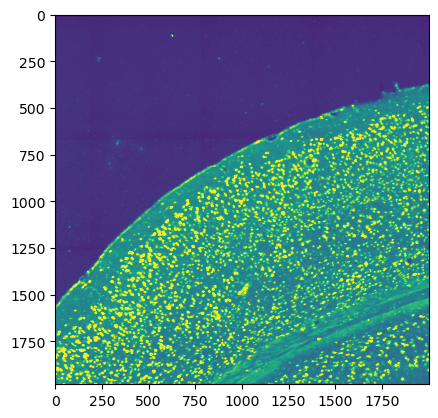

In [ ]:
projection = np.nanmean(out, axis=0)
plt.imshow(projection[100:10000:5, 5000:15000:5], vmax=100)


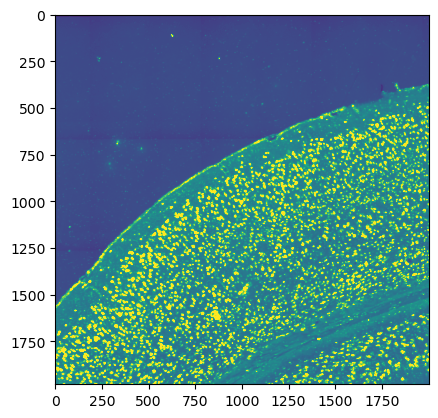

In [ ]:
projection = np.nanmax(out, axis=0)
plt.imshow(projection[100:10000:5, 5000:15000:5], vmax=200)


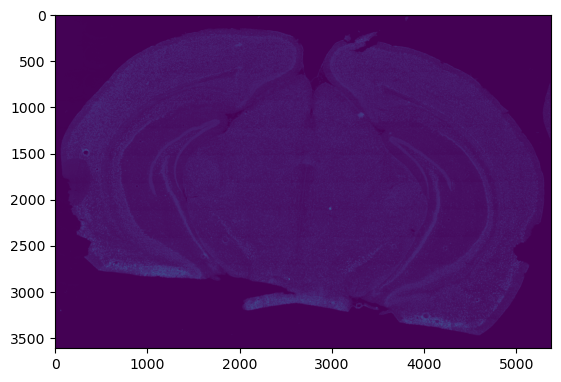

In [ ]:
projection = np.nanmin(out, axis=0)
plt.imshow(projection[::10, ::10])


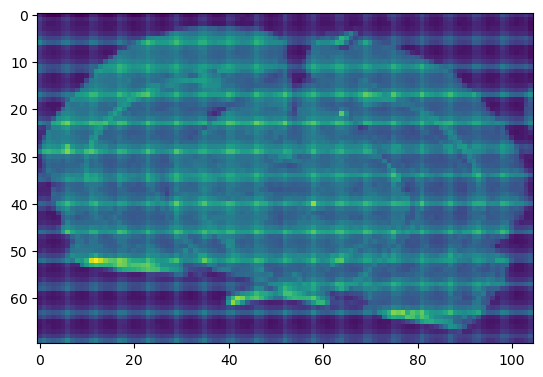

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(smallest)


In [ ]:
import matplotlib.pyplot as plt

minp = np.nanmin(out, axis=0)


In [ ]:
print("Copy array")
fig = plt.figure(figsize=(15, 4))
image = np.array(minp)
plt.subplot(1, 3, 1)
plt.imshow(image[::20, ::20])
plt.colorbar()
print("Normalised")
p = np.nanquantile(image, 0.05)
q = np.nanquantile(image, 0.999)
image = (image - p) * 255 / (q - p)
plt.subplot(1, 3, 2)
plt.imshow(image[::20, ::20])
plt.colorbar()
print("Converting")
image = np.clip(image, 0, 255)
image = np.array(image, dtype="uint8")
plt.subplot(1, 3, 3)
plt.imshow(image[::20, ::20])
plt.colorbar()
